# reproducing a figure from Avseth et al., 2001

This is a little detour, a minor thing, one of those little distractions that nonetheless have a catastrophic effect on my productivity. 

Here's the story:

These last few weeks I have been busy implementing the concept of AVO projections (Whitcombe, 2002; Simm & Bacon, 2014) in my daily work; at the end I was probably more happy to have been able to put together a neat little workflow doing almost(*) everything in Python than the actual results which are, as usual in geosciences, full of unknowns.

Anyway, I wanted to share the way I did things, which meant reproducing all the work with openly accessible data. Most of the data I am using for these [notes that I'm writing](https://github.com/aadm/geophysical_notes) come from a wonderful book written in 2005 by Per Avseth, Tapan Mukerji and Gary Mavko, "Quantitative Seismic Interpretation" (QSI)(**); a few months ago I wrote [a little tutorial on seismic petrophysics](http://nbviewer.ipython.org/github/aadm/geophysical_notes/blob/master/seismic_petrophysics.ipynb) using well data from the [QSI test dataset](https://srb.stanford.edu/quantitative-seismic-interpretation), and since 3D seismic cubes were also available in here I began using those to describe my work on AVO projections, until I found some discrepancies with the material that Avseth et al. have published.

There was one particular figure that bothered me, because I was not really able to understand if there was anything wrong with data loading or what else; it is the one at page 259, figure 5.1; it is also present in [Avseth's PhD thesis](https://pangea.stanford.edu/researchgroups/srb/resources/theses) and in a paper published in 2001 (Avseth et al., 2001).

***

(*) _Horizon picking is obviously still a thing for the large interpretation platforms, and I see no future to replace those with any Python-based solution._

(**) _This book strikes a perfect compromise between theory and practice, and it never gets old; "after all these years", I am still using it for inspiration, reference and as a practical guide for my daily job._

## the original figure

Let's see this figure:

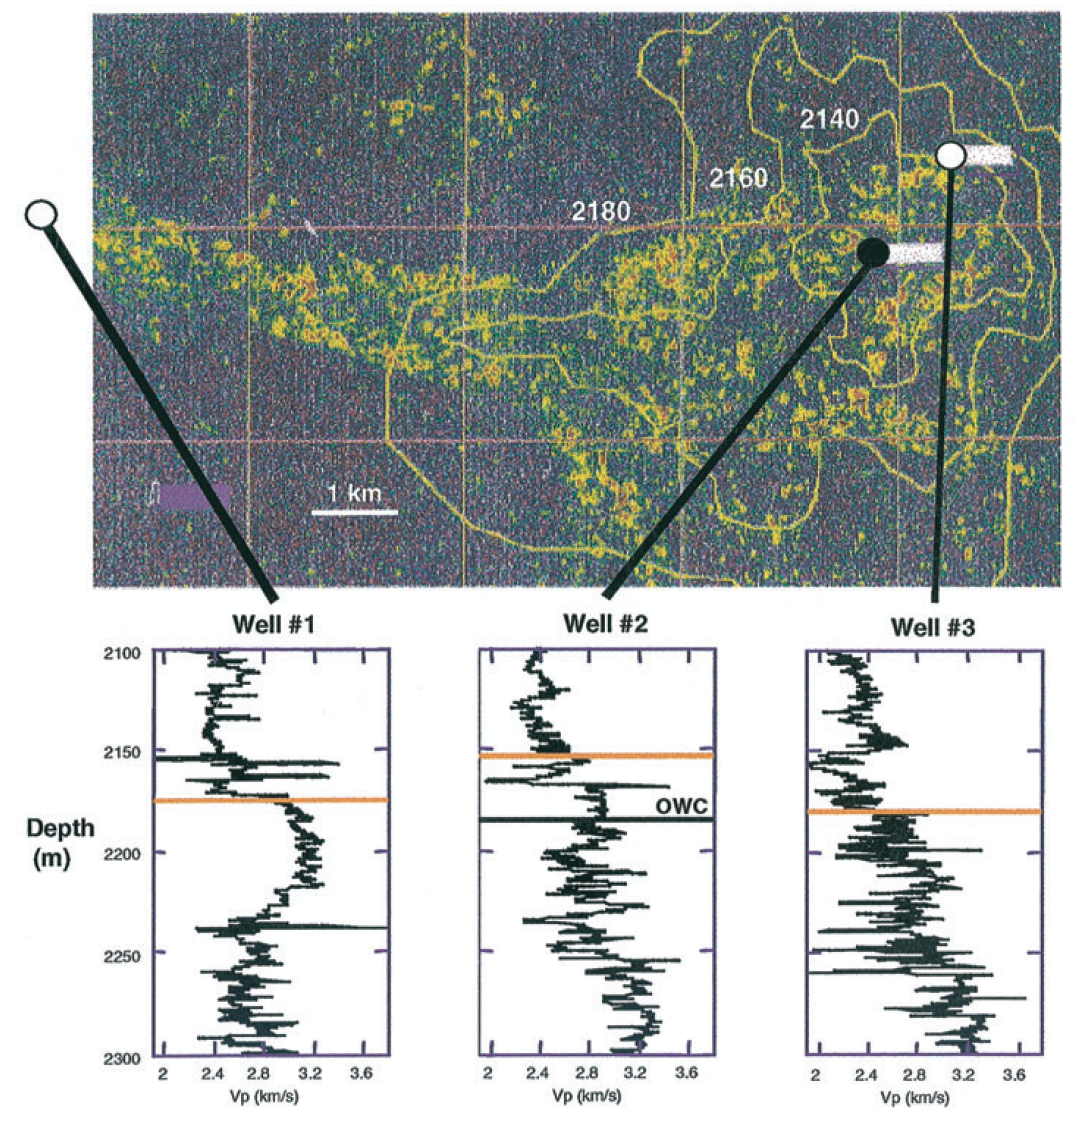

In [1]:
from IPython.display import Image
Image(filename='Avseth_2001_fig1.png', width=800)

### loading well data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import segypy
from scipy.interpolate import griddata
import scipy.ndimage as ndimage

%matplotlib inline
# comment out the following if you're not on a Mac with HiDPI display
%config InlineBackend.figure_format = 'retina'

In [3]:
w1=np.loadtxt('well_1.txt',skiprows=1)
w1z=w1[:,0]
w1vp=w1[:,2]

w2=np.recfromcsv('qsiwell2.csv',names=True)
w2z=w2['depth']
w2vp=w2['vp']/1e3

w3=np.recfromcsv('qsiwell3.csv',names=True)
w3z=w3['depth']
w3vp=w3['vp']/1e3

w5=np.recfromcsv('qsiwell5.csv',names=True)
w5z=w5['depth']
w5vp=304.800/w5['dt']

well1_il, well1_xl = 1448, 945
well2_il, well2_xl = 1376, 1776
well3_il, well3_xl =1468, 1847

tops_w1={'Heimdal': 2170}
tops_w2={'Heimdal': 2153,'OWC': 2183}
tops_w3={'Heimdal': 2180}

### loading seismic  data and interpretation

In [4]:
inl=np.arange(1300,1502,2)
crl=np.arange(1500,2002,2)
hrz=np.recfromtxt('Top_Heimdal_subset.txt', names=['il','xl','z'])

filename='3d_nearstack.sgy'
f=open(filename, 'rb')
seis,header,trace_headers=segypy.read_segy(f)
near=seis.reshape(header['ns'],inl.size,crl.size)

lagtime=trace_headers['LagTimeA'][0]*-1
twt=np.arange(lagtime,header['dt']/1e3*header['ns']+lagtime,header['dt']/1e3)

### amplitude extraction

This is the raw extraction along the Top Heimdal horizon; see also my other notebook which describes in more detail [how to do amplitude extractions in Python](http://nbviewer.ipython.org/github/aadm/geophysical_notes/blob/master/seismic_amplitude_extraction.ipynb).

In [5]:
amp=np.zeros(hrz.size)
for i in range(hrz.size):
    ii_idx = inl.tolist().index(hrz['il'][i])
    cc_idx = crl.tolist().index(hrz['xl'][i])
    zz_idx = np.abs(twt-hrz['z'][i]).argmin()
    amp[i] = near[zz_idx, ii_idx, cc_idx].flatten()

### gridding interpretation and amplitude maps

In [6]:
xi = np.linspace(inl.min(), inl.max(),500)
yi = np.linspace(crl.min(), crl.max(),500)
X, Y = np.meshgrid(xi, yi)
Z=griddata((hrz['il'],hrz['xl']),hrz['z'],(X,Y),method='cubic')
A=griddata((hrz['il'],hrz['xl']),amp,(X,Y),method='cubic')

# smoothing the time interpretation because it looks better when contoured
Zf=ndimage.gaussian_filter(Z,sigma=8,order=0)

### reproducing the damn figure!

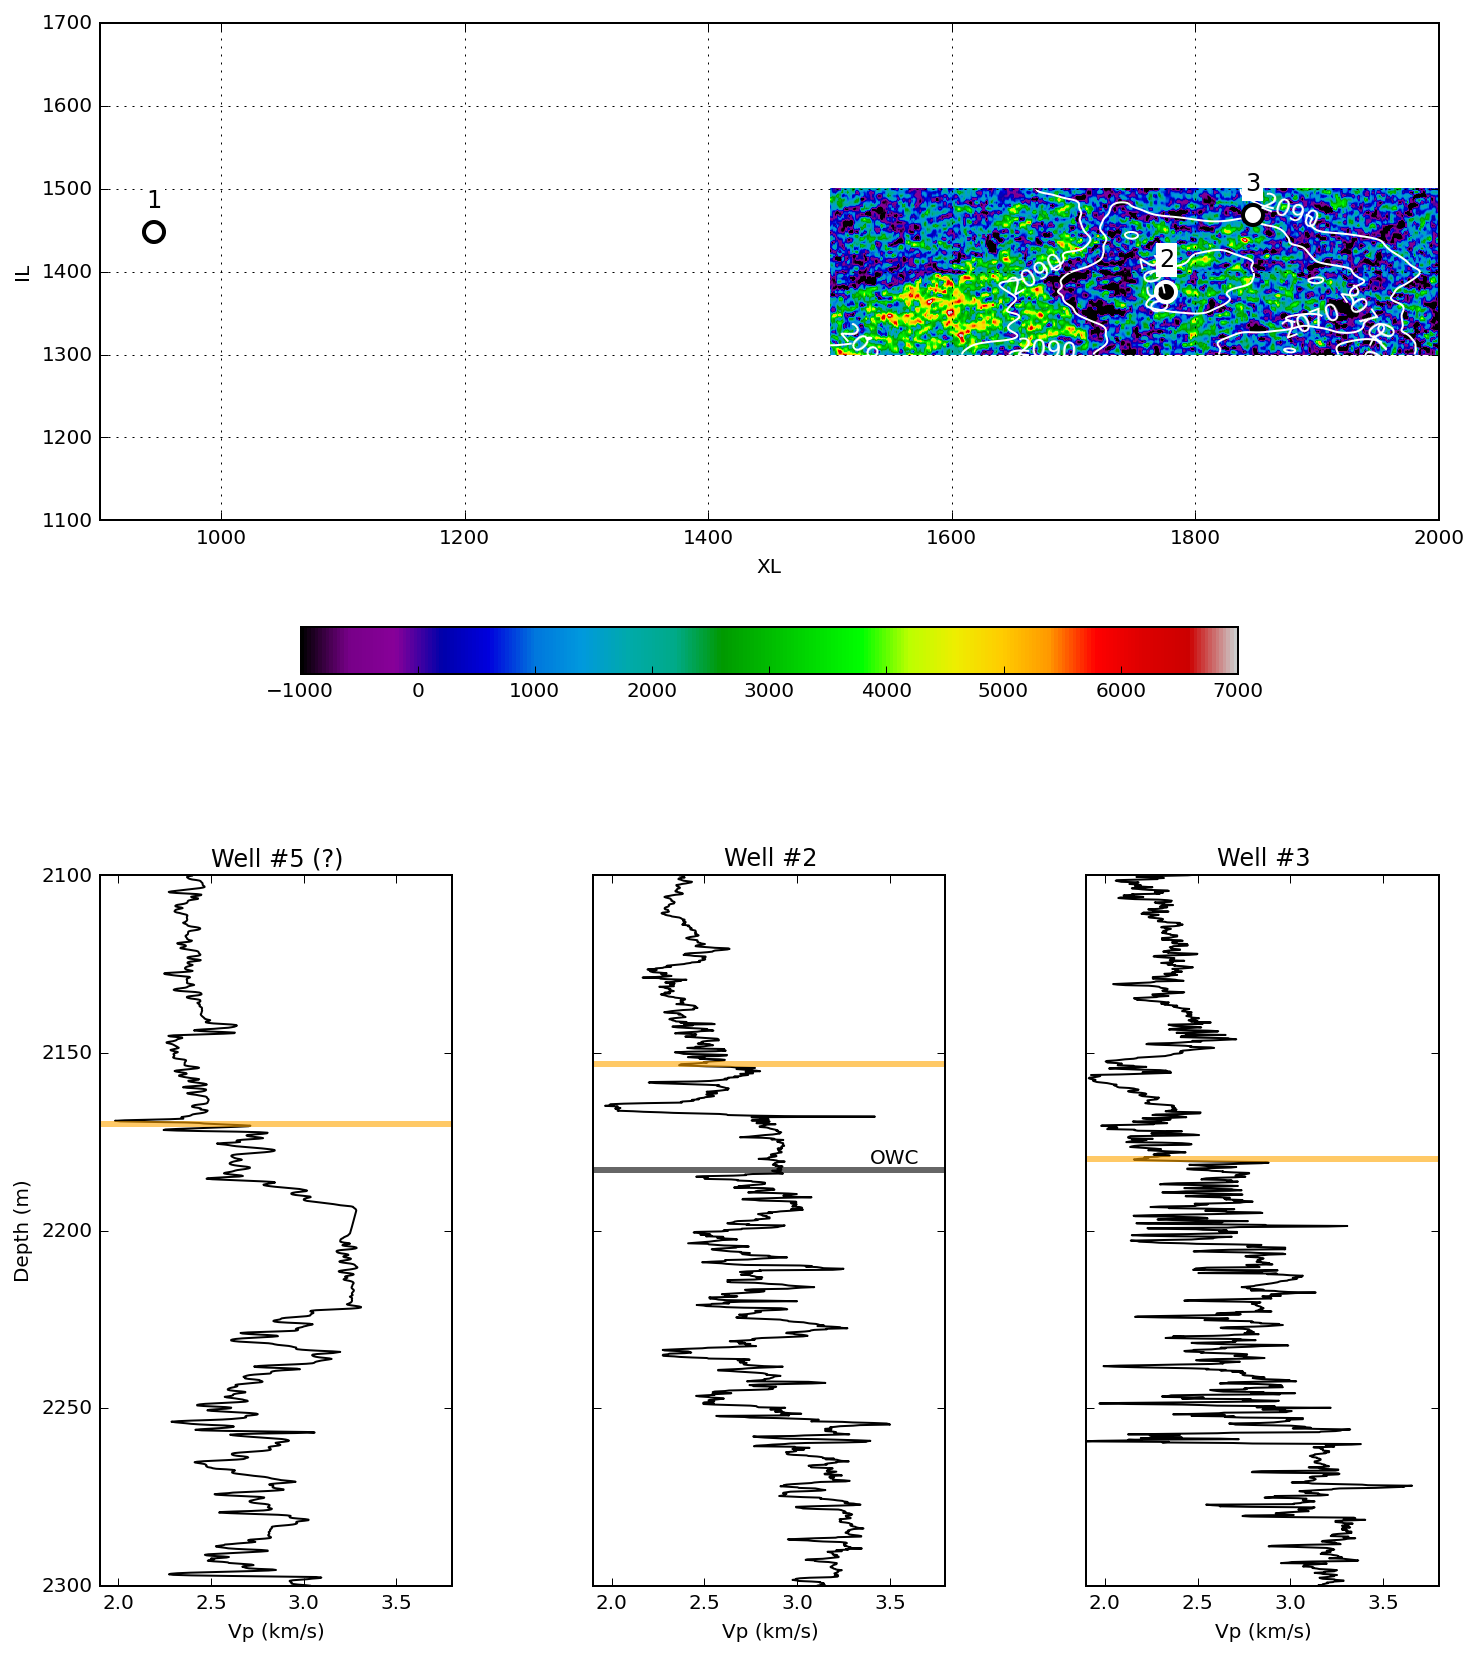

In [9]:
f,ax=plt.subplots(figsize=(12, 14),facecolor='w')
ax0 = plt.subplot2grid((2,3), (0, 0), colspan=3)
#...uncomment the following to display the time interpretation of Top Heimdal
# im0=ax0.pcolormesh(Y,X,Z,cmap='gist_earth_r')
im0=ax0.pcolormesh(Y, X, A, cmap='nipy_spectral', vmin=-1000,vmax=7000)
CS=ax0.contour(Y,X,Zf,levels=[2050,2070,2090],colors='w')
ax0.clabel(CS, inline=1, fontsize=12, fmt='%.0f')
plt.colorbar(im0, ax=ax0, orientation='horizontal', shrink=0.7)
ax0.plot(well1_xl,well1_il,'ow',ms=10,mew=2)
ax0.text(well1_xl,well1_il+30,'1',ha='center',backgroundcolor='w',fontsize=12, color='k')
ax0.plot(well2_xl,well2_il,'ok',ms=10,mew=2,mec='w')
ax0.text(well2_xl,well2_il+30,'2',ha='center',backgroundcolor='w',fontsize=12,color='k')
ax0.plot(well3_xl,well3_il,'ow',ms=10,mew=2)
ax0.text(well3_xl,well3_il+30,'3',ha='center',backgroundcolor='w',fontsize=12, color='k')
ax0.set_xlabel('XL'), ax0.set_ylabel('IL')
ax0.set_xlim(900,2000), ax0.set_ylim(1100,1700)
ax0.grid()
ax1 = plt.subplot2grid((2,3), (1, 0))
ax1.plot(w5vp,w5z,'-k')
ax1.set_title('Well #5 (?)')
ax1.set_ylabel('Depth (m)')
ax1.axhline(y=float(tops_w1['Heimdal']),color='orange',lw=3,alpha=0.6)
ax2 = plt.subplot2grid((2,3), (1, 1))
ax2.plot(w2vp,w2z,'-k')
ax2.set_title('Well #2')
ax2.axhline(y=float(tops_w2['Heimdal']),color='orange',lw=3,alpha=0.6)
ax2.axhline(y=float(tops_w2['OWC']),color='black',lw=3,alpha=0.6)
ax2.text(3.4,tops_w2['OWC']-2,'OWC')
ax3 = plt.subplot2grid((2,3), (1, 2))
ax3.plot(w3vp,w3z,'-k')
ax3.set_title('Well #3')
ax3.axhline(y=float(tops_w3['Heimdal']),color='orange',lw=3,alpha=0.6)
f.subplots_adjust(wspace=.4)
for aa in [ax1, ax2,ax3]:
    aa.set_xlabel('Vp (km/s)')
    aa.set_ylim(2300,2100)
    aa.set_xlim(1.9,3.8)
    if aa != ax1:
        aa.set_yticklabels([])

## the problems with this figure

First, the amplitude map is much smaller than the original figure but that's something I knew in advance as the 3D cubes included in the dataset are declared to "subcubes".

The original colorscale was also a guess; apart from being horrible, there is also no colorbar in any instance of that figure (a pretty much incredible oversight from the authors; if I were to show a map with no colorbar to any minor conference people would literally slap me in the face without hearing any excuse!). I used `nipy_spectral` and adjusted the extremes to get something similar.

I assumed that inlines were North-South and increasing upwards, while crosslines were East-West; in all [the other uses I made of this dataset](http://nbviewer.ipython.org/github/aadm/geophysical_notes/blob/master/seismic_amplitude_extraction.ipynb) I have always used inlines as E-W and crosslines as N-S. But only this orientation matches the position of the 3 wells with those of the original figure.

The main thing that bothered me was the time contours; the original figure had 3 contours at 2140, 2160 and 2180 ms showing the Top Heimdal structure. I have the same interpreted horizon, but after gridding and contouring it the values are lower and I only see a vague resemblance of the original shape using the 2050, 2070 and 2090 ms contour lines.

Also the amplitude patterns don't quite match but they are difficult to judge because we are looking at a much restricted area and also because I don't know what are the original parameters used to create that map (on the papers this map is referred to as a "reflectivity map"). However, there is a certain consistency between the two figures if we compare the area to the left of well 2.

The second major problem that I have is that the leftmost well is always called "well 1", but the velocity log in this well doesn't look anything like the one in the figure -- check this out:

(1.9, 3.8)

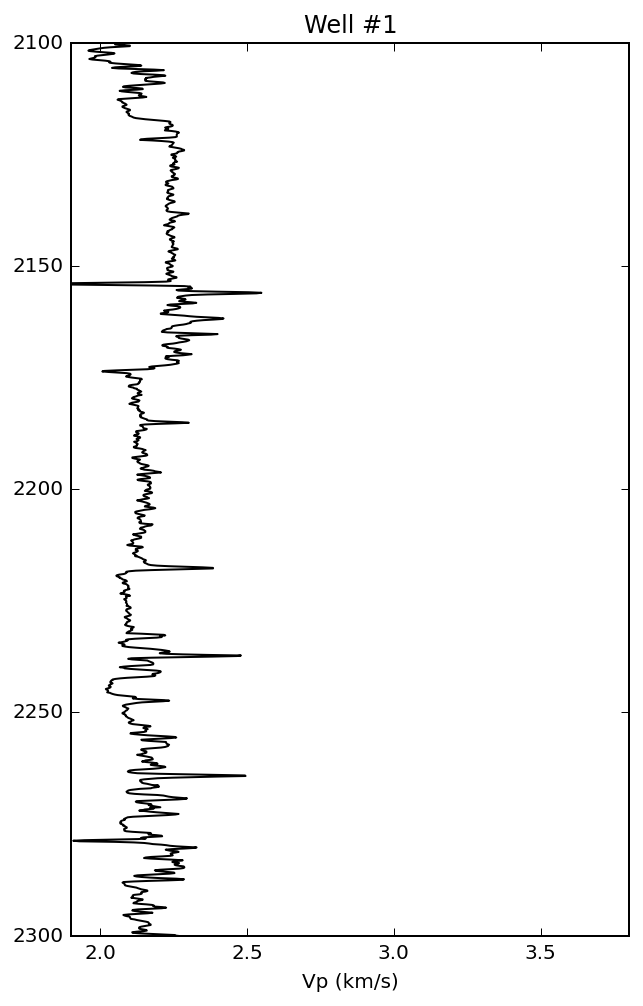

In [8]:
plt.figure(figsize=(5,8))
plt.plot(w1vp,w1z,'-k')
plt.title('Well #1')
plt.xlabel('Vp (km/s)')
plt.ylim(2300,2100)
plt.xlim(1.9,3.8)

So this is why I have kept the coordinates from well 1 but used the data from well 5 in the figure above; there is still some difference that could be due to some despiking and data editing but the overall pattern is very much like the original "well 1".

I haven't done any further comparison because I really have a life after all.

## references

* Avseth et al.: Seismic reservoir mapping from 3-D AVO in a North Sea turbidite system, Geophysics, 2001.
* Whitcombe, Elastic impedance normalization, Geophysics, 2002.
* Simm & Bacon, Seismic Amplitude: An Interpreter's Handbook, Cambridge University Press, 2014.